In [1]:
import os
os.mkdir('output')
!pwd

/content


In [0]:
import glob
import os
import random
import time
import datetime
import sys
import argparse
import itertools
import json

import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset
from PIL import Image

In [3]:
# Download Pokemon Dataset
!git clone https://github.com/rileynwong/pokemon-images-dataset-by-type/

Cloning into 'pokemon-images-dataset-by-type'...
remote: Enumerating objects: 849, done.
remote: Counting objects: 100% (849/849), done.
remote: Compressing objects: 100% (841/841), done.
remote: Total 849 (delta 18), reused 830 (delta 7), pack-reused 0
Receiving objects: 100% (849/849), 2.38 MiB | 6.22 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [4]:
!ls pokemon-images-dataset-by-type

# Define Domain X and Domain Y
# You can choose fom option available

# dragon, fighting, ghost, ice, psychic, steel
# bug, electric, fire, grass, normal, water
# dark, fairy, flying, ground, poison, rock

domainX = "water"
domainY = "grass"

all   dragon	fighting  ghost   ice	  psychic    steel
bug   electric	fire	  grass   normal  README.md  water
dark  fairy	flying	  ground  poison  rock


In [0]:
# Residual Block
class ResnetBlock(nn.Module):
  def __init__(self, dim):
    super(ResnetBlock, self).__init__()
    self.conv = self.build(dim)
  
  def build(self, dim):
    conv = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(dim, dim, kernel_size=3),
        nn.InstanceNorm2d(dim),
        nn.ReLU(True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(dim, dim, kernel_size=3),
        nn.InstanceNorm2d(dim))
    
    return conv
  
  def forward(self, x):
    return x + self.conv(x)

In [0]:
# Generator aka G
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(3, 64, kernel_size=7, padding=0),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),

        #downsampling
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),

        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU(True),

        #ResnetBlock
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),
        ResnetBlock(256),

        #upsampling
        nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, 7),
        nn.Tanh())
  
  def forward(self, x):
    return self.model(x)

In [0]:
# Discriminator aka D
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 64, 4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, stride=2, padding=1),
        nn.InstanceNorm2d(128), 
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, stride=2, padding=1),
        nn.InstanceNorm2d(256), 
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, padding=1),
        nn.InstanceNorm2d(512), 
        nn.LeakyReLU(0.2, inplace=True),

        # FCN classification layer
        nn.Conv2d(512, 1, 4, padding=1))
  
  def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        # return x

In [0]:
# Random Weight Initilization
def weights_init_normal(model):
  if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
    torch.nn.init.normal(model.weight.data, 0.0, 0.02)

In [0]:
# Pokemon DataLoader
# https://github.com/utkuozbulak/pytorch-custom-dataset-examples
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s' % domainX) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s' % domainY) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
# Borrowed from "Learning from Simulated and Unsupervised Images through Adversarial Training"
class ImagePool():
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def push_and_pop(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else: 
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)
        return return_images

In [0]:
# Helper to convert PyTorch Tensor to image
def tensor2im(input_image, imtype=np.uint8):
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [0]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [0]:
class CycleGAN(object):
  def __init__(self, train=True):
    self.train = train
    self.initialize()
    self.init_weights()

  def initialize(self):
    self.netG_A2B = Generator()
    self.netG_B2A = Generator()
    self.netG_A2B.cuda()
    self.netG_B2A.cuda()

    if self.train:
      self.netD_A = Discriminator()
      self.netD_B = Discriminator()
      self.netD_A.cuda()
      self.netD_B.cuda()
    
    if self.train:
      self.criterion_GAN = torch.nn.MSELoss()
      self.criterion_cycle = torch.nn.L1Loss()
      self.criterion_identity = torch.nn.L1Loss()

      self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()),
                                      lr=0.0002, betas=(0.5, 0.999))
      self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
      self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

      self.lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
      self.lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
      self.lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

      self.fake_A_buffer = ImagePool()
      self.fake_B_buffer = ImagePool()

    Tensor = torch.cuda.FloatTensor
    self.input_A = Tensor(1, 3, 256, 256)
    self.input_B = Tensor(1, 3, 256, 256)
    self.target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
    self.target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

  def init_weights(self):
    self.netG_A2B.apply(weights_init_normal)
    self.netG_B2A.apply(weights_init_normal)
    self.netD_A.apply(weights_init_normal)
    self.netD_B.apply(weights_init_normal)

  def set_input(self, data):
    self.real_A = Variable(self.input_A.copy_(data['A']))
    self.real_B = Variable(self.input_B.copy_(data['B']))

  def forward(self, data):
    self.set_input(data)
    self.fake_B = self.netG_A2B(self.real_A)
    self.recovered_A = self.netG_B2A(self.fake_B)
    self.fake_A = self.netG_B2A(self.real_B)
    self.recovered_B = self.netG_A2B(self.fake_A)
  
  def optimize_G_parameters(self):
    self.optimizer_G.zero_grad()
    self.backward_G()
    self.optimizer_G.step()
  
  def optimize_D_parameters(self):
    self.backward_D()
  
  def backward_D(self):
    self.optimizer_D_A.zero_grad()

    # Real loss
    pred_real = self.netD_A(self.real_A)
    self.loss_D_real = self.criterion_GAN(pred_real, self.target_real)

    # Fake loss
    fake_A = self.fake_A_buffer.push_and_pop(self.fake_A)
    pred_fake = self.netD_A(fake_A.detach())
    self.loss_D_fake = self.criterion_GAN(pred_fake, self.target_fake)

    # Total loss
    self.loss_D_A = (self.loss_D_real + self.loss_D_fake)*0.5
    self.loss_D_A.backward()

    self.optimizer_D_A.step()

    self.optimizer_D_B.zero_grad()

    # Real loss
    pred_real = self.netD_B(self.real_B)
    self.loss_D_real = self.criterion_GAN(pred_real, self.target_real)
    
    # Fake loss
    fake_B = self.fake_B_buffer.push_and_pop(self.fake_B)
    pred_fake = self.netD_B(fake_B.detach())
    self.loss_D_fake = self.criterion_GAN(pred_fake, self.target_fake)

    # Total loss
    self.loss_D_B = (self.loss_D_real + self.loss_D_fake)*0.5
    self.loss_D_B.backward()

    self.optimizer_D_B.step()
   
  def identity_loss(self):
    self.same_B = self.netG_A2B(self.real_B)
    self.loss_identity_B = self.criterion_identity(self.same_B, self.real_B)*5.0
    self.same_A = self.netG_B2A(self.real_A)
    self.loss_identity_A = self.criterion_identity(self.same_A, self.real_A)*5.0
    
  def gan_loss(self):
    pred_fake = self.netD_B(self.fake_B)
    self.loss_GAN_A2B = self.criterion_GAN(pred_fake, self.target_real)

    pred_fake = self.netD_A(self.fake_A)
    self.loss_GAN_B2A = self.criterion_GAN(pred_fake, self.target_real)

  def cycle_loss(self):
    self.loss_cycle_ABA = self.criterion_cycle(self.recovered_A, self.real_A)*10.0

    self.loss_cycle_BAB = self.criterion_cycle(self.recovered_B, self.real_B)*10.0

  def total_loss(self):
    self.loss_G = self.loss_identity_A + self.loss_identity_B + self.loss_GAN_A2B + self.loss_GAN_B2A + self.loss_cycle_ABA + self.loss_cycle_BAB
    self.loss_G.backward()
    
  def backward_G(self):
    self.identity_loss()
    self.gan_loss()
    self.cycle_loss()
    self.total_loss()

  def update_lr(self):
    self.lr_scheduler_G.step()
    self.lr_scheduler_D_A.step()
    self.lr_scheduler_D_B.step()

  def save_model(self):
    torch.save(self.netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(self.netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(self.netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(self.netD_B.state_dict(), 'output/netD_B.pth')
  
  def print(self, epoch):
    loss = {'epoch': epoch, 'loss_G': self.loss_G.item(), 'loss_G_identity': (self.loss_identity_A.item() + self.loss_identity_B.item()), 'loss_G_GAN': (self.loss_GAN_A2B.item() + self.loss_GAN_B2A.item()),
                    'loss_G_cycle': (self.loss_cycle_ABA.item() + self.loss_cycle_BAB.item()), 'loss_D': (self.loss_D_A.item() + self.loss_D_B.item())}
    with open('output/loss', 'a') as f:
        f.write(json.dumps(loss) + "\n")
    print(loss)

  def show_images(self):
    plt.figure(figsize=(12, 12))

    display_list = [self.real_A, self.fake_B]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(tensor2im(display_list[i]))
      plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(12, 12))

    display_list = [self.real_B, self.fake_A]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(tensor2im(display_list[i]))
      plt.axis('off')
    plt.show()

In [0]:
transforms_ = [transforms.Resize(286, Image.BICUBIC), 
               transforms.RandomCrop(256), 
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
dataloader = DataLoader(ImageDataset("pokemon-images-dataset-by-type/", transforms_=transforms_, unaligned=True), 
batch_size=1, shuffle=True, num_workers=8)

In [0]:
def test():
    netG_A2B = Generator()
    netG_B2A = Generator()
    netG_A2B.cuda()
    netG_B2A.cuda()

    netG_A2B.load_state_dict(torch.load('output/netG_A2B.pth'))
    netG_B2A.load_state_dict(torch.load('output/netG_B2A.pth'))

    netG_A2B.eval()
    netG_B2A.eval()

    Tensor = torch.cuda.FloatTensor
    input_A = Tensor(1, 3, 256, 256)
    input_B = Tensor(1, 3, 256, 256)


    transforms_ = [transforms.Resize(256, Image.BICUBIC),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
    dataloader = DataLoader(ImageDataset("pokemon-images-dataset-by-type/", transforms_=transforms_, unaligned=True), 
    batch_size=1, shuffle=True, num_workers=8)
    
    dirA = 'output/' + domainX + '_Fake'
    dirB = 'output/' + domainY + '_Fake'
    if not os.path.exists(dirA):
        os.makedirs(dirA)
    if not os.path.exists(dirB):
        os.makedirs(dirB)

    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        # Generate output
        fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
        fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

        # Save image files
        fileA = dirA + '/' + str(i+1) + '.png'
        fileB = dirB + '/' + str(i+1) + '.png'
        save_image(fake_A, fileA)
        save_image(fake_B, fileB)
    sys.stdout.write('Done\n')

Epoch : 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py

{'epoch': 0, 'loss_G': 2.2598636150360107, 'loss_G_identity': 0.5154487490653992, 'loss_G_GAN': 0.6386906504631042, 'loss_G_cycle': 1.1057241559028625, 'loss_D': 0.4595997631549835}


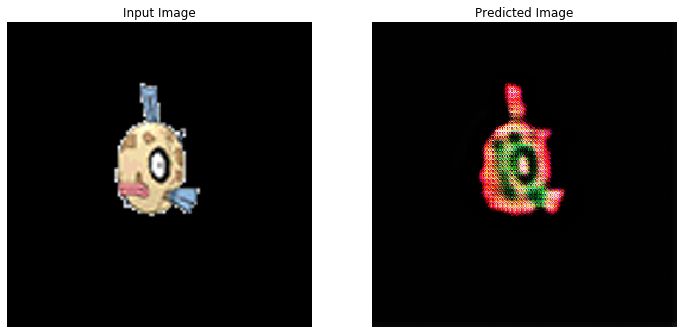

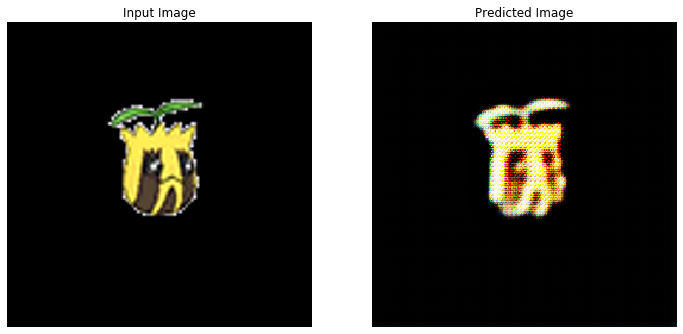

Epoch : 1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   

{'epoch': 1, 'loss_G': 2.5292792320251465, 'loss_G_identity': 0.7152908444404602, 'loss_G_GAN': 0.24933933839201927, 'loss_G_cycle': 1.5646489262580872, 'loss_D': 0.4652441516518593}


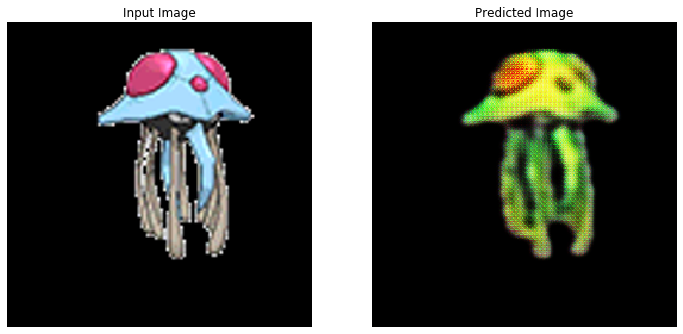

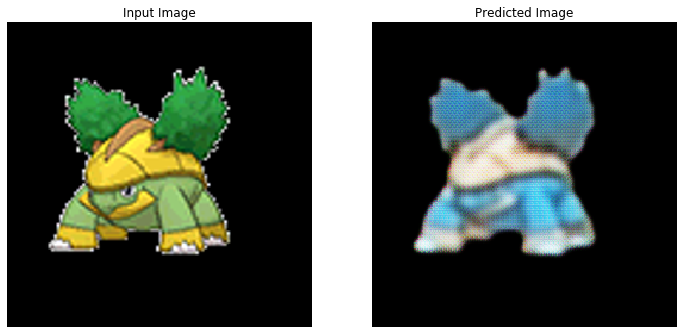

Epoch : 2


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   

KeyboardInterrupt: ignored

In [16]:
model = CycleGAN()
for epoch in range(0, 200):
    print("Epoch : " + str(epoch))
    for i, batch in enumerate(dataloader):
        model.forward(batch)
        model.optimize_G_parameters()
        model.optimize_D_parameters()
    model.print(epoch)    
    model.show_images()
    model.update_lr()
    model.save_model()

In [0]:
test()

### References


*   https://github.com/NVIDIA/pix2pixHD/blob/master/util/util.py
*   https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pixeb6e7dce7940033d84791b87c1a9670e67fa968d/util/image_pool.py


